### Àlex Correa Orri 1564967
### Júlia Pumares Benaiges 1566252

#### Dataset explicat: https://rpubs.com/rhuebner/hrd_cb_v14
#### Descàrrega dataset: https://www.kaggle.com/rhuebner/human-resources-data-set

In [133]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  (), please run `%reset?` for details


### MÒDULS I LLIBRERIES

In [134]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
import os
import seaborn as sns
from scipy.stats import shapiro, spearmanr
import math
from sklearn.linear_model import LinearRegression

### DIRECTORI DE TREBALL

In [135]:
os.getcwd()
path = 'C:/Users/alexc/OneDrive/Escritorio/UNI/3er/Aprenentatge Computacional/pràctiques/PRÀCTICA 1'
os.chdir(path)
os.getcwd()
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### LECTURA DE DADES

In [136]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('HRDataset_v14_.csv')

### MODIFICACIÓ DEL DATASET

#### ELiminem atributs

In [137]:
dataset = dataset.drop(['Employee_Name','EmpID', 'MarriedID', 'DeptID', 'Zip', 'ManagerID', 'LastPerformanceReview_Date', 'MaritalStatusID', 'EmpStatusID', 'PositionID', 'Sex', 'PerformanceScore'], axis=1) 
dataset.HispanicLatino = dataset.HispanicLatino.replace({'No': 0, 'no': 0, 'Yes': 1, 'yes': 1})

#### Modifiquem atributs de dates a valors numèrics en dies

In [138]:
def date2date(list_dates):
    list_dates_def = []
    for date in list_dates:
        if (len(date.split('/')[2]) == 2):
            s = date.split('/')
            s[2] = '19'+s[2]
            date = s[0]+'/'+s[1]+'/'+s[2]
        list_dates_def.append(date)
    return list_dates_def

In [139]:
today = '1/1/2020'
#passem les dates (date of hire i date of termination) a date_time
dataset['DateofHire'] = pd.to_datetime(dataset['DateofHire'], format='%m/%d/%Y')
dataset['DateofTermination'].fillna(today, inplace = True) #posem 2020 com a data actual o de referència
dataset['DateofTermination'] = pd.to_datetime(dataset['DateofTermination'], format='%m/%d/%Y')
dataset['WorkedDays'] = (dataset['DateofTermination'] - dataset['DateofHire']).astype('timedelta64[D]')
dataset = dataset.drop(['DateofTermination', 'DateofHire'], axis=1)
#passem DOB a datetime i ho transformem a edat (per tenir una valor numèric)
dataset['DOB'] = date2date(dataset['DOB'])
dataset['DOB'] = pd.to_datetime(dataset['DOB'], format='%m/%d/%Y')
dataset['Age'] = (pd.to_datetime(today, format='%m/%d/%Y') - dataset['DOB']).astype('timedelta64[D]')
dataset = dataset.drop(['DOB'], axis=1)

#### Passem les columnes categòriques a binàries

In [140]:
columns = ['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc']

for col in columns:
    if dataset[col].dtype == 'object':
        #print(col)
        dataset = pd.concat([dataset, pd.get_dummies(dataset[col], prefix=col)], axis=1)


In [141]:
dataset = dataset.drop(['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc'], axis=1) 

In [142]:
dataset = dataset.rename(columns={'Department_Production       ': 'Department_Production'})

### INFORMACIÓ DEL DATASET

In [143]:
data = dataset.values

x = data[:, :311]
y = data[:, 3]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (311, 144)
Dimensionalitat de les entrades X (311, 144)
Dimensionalitat de l'atribut Y (311,)


In [144]:
print("Print dataset:")
print(dataset)

Print dataset:
     GenderID  PerfScoreID  FromDiversityJobFairID  Salary  Termd  \
0           1            4                       0   62506      0   
1           1            3                       0  104437      1   
2           0            3                       0   64955      1   
3           0            3                       0   64991      0   
4           0            3                       0   50825      1   
..        ...          ...                     ...     ...    ...   
306         1            3                       0   65893      0   
307         0            1                       0   48513      1   
308         0            4                       0  220450      0   
309         0            3                       0   89292      0   
310         0            3                       0   45046      0   

     HispanicLatino  EngagementSurvey  EmpSatisfaction  SpecialProjectsCount  \
0                 0             4.600                5                     0

In [145]:
print(dataset.describe())
list(dataset.columns)

       GenderID  PerfScoreID  FromDiversityJobFairID     Salary   Termd  \
count   311.000      311.000                 311.000    311.000 311.000   
mean      0.434        2.977                   0.093  69020.685   0.334   
std       0.496        0.587                   0.291  25156.637   0.473   
min       0.000        1.000                   0.000  45046.000   0.000   
25%       0.000        3.000                   0.000  55501.500   0.000   
50%       0.000        3.000                   0.000  62810.000   0.000   
75%       1.000        3.000                   0.000  72036.000   1.000   
max       1.000        4.000                   1.000 250000.000   1.000   

       HispanicLatino  EngagementSurvey  EmpSatisfaction  \
count         311.000           311.000          311.000   
mean            0.090             4.110            3.891   
std             0.287             0.790            0.909   
min             0.000             1.120            1.000   
25%             0.000   

['GenderID',
 'PerfScoreID',
 'FromDiversityJobFairID',
 'Salary',
 'Termd',
 'HispanicLatino',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'DaysLateLast30',
 'Absences',
 'WorkedDays',
 'Age',
 'CitizenDesc_Eligible NonCitizen',
 'CitizenDesc_Non-Citizen',
 'CitizenDesc_US Citizen',
 'RaceDesc_American Indian or Alaska Native',
 'RaceDesc_Asian',
 'RaceDesc_Black or African American',
 'RaceDesc_Hispanic',
 'RaceDesc_Two or more races',
 'RaceDesc_White',
 'TermReason_Another position',
 'TermReason_Fatal attraction',
 'TermReason_Learned that he is a gangster',
 'TermReason_N/A-StillEmployed',
 'TermReason_attendance',
 'TermReason_career change',
 'TermReason_gross misconduct',
 'TermReason_hours',
 'TermReason_maternity leave - did not return',
 'TermReason_medical issues',
 'TermReason_military',
 'TermReason_more money',
 'TermReason_no-call, no-show',
 'TermReason_performance',
 'TermReason_relocation out of area',
 'TermReason_retiring',
 'TermReason_retu

### ANALITZANT LES DADES

#### Buscant atributs amb distribució Gaussiana

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


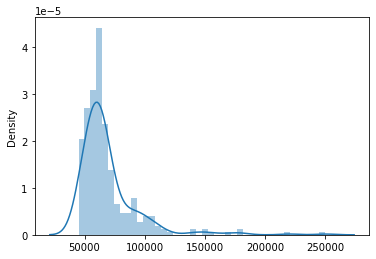

In [146]:
#provem amb el salari
ax = sns.distplot(x[:,3])


#### Visualització de les relacions entre atributs

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


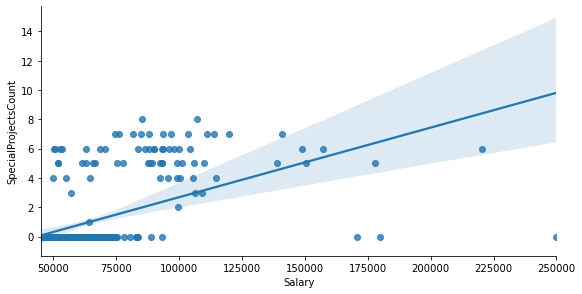

In [147]:
# Visualització de la relacó entre el salari i el recompte de projectes (SpecialProjectsCount)
sns.lmplot('Salary', 'SpecialProjectsCount', dataset, order = 1,size = 4, aspect = 2)

C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexc\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


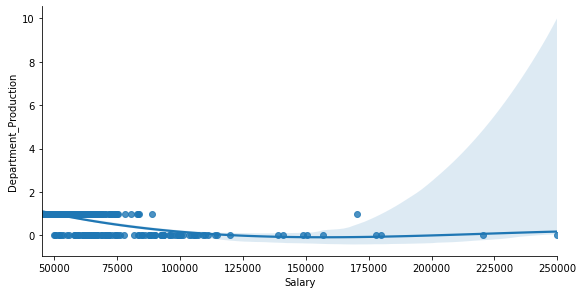

In [151]:
sns.lmplot('Salary', 'Department_Production', dataset, order = 3,size = 4, aspect = 2)

In [72]:
#Normallity tests
#HISTOGRAMA
c = 0
for col in dataset.columns:
    stat, p = shapiro(x[:,c])
    if p > 0.005:
        print(c)
        print(p)
        print(dataset.columns[c])
    c += 1
#v = 2
#ax = sns.distplot(x[:,v])
#no hi ha cap atribut amb distribució normal

11
0.012815523892641068
WorkedDays


#### Busquem correlació entre els atributs

In [73]:
#correlació de Spearman (per a distribucions no gaussianes)
i=0
cols_corr = []
for col in dataset.columns:
    s, p = spearmanr(x[:,i], y)
    if (abs(s) > 0.10 and p < 0.05):
        print('Atribut '+ str(i) + ' ' + col)
        cols_corr.append(col)
        print(spearmanr(x[:,i], y))
        print("-----------------------------------------------------------------------------------")
    i = i + 1
#p-value < 0.05 la correlació és significant

Atribut 3 Salary
SpearmanrResult(correlation=1.0, pvalue=0.0)
-----------------------------------------------------------------------------------
Atribut 8 SpecialProjectsCount
SpearmanrResult(correlation=0.5068658370578706, pvalue=1.0553505548976915e-21)
-----------------------------------------------------------------------------------
Atribut 11 WorkedDays
SpearmanrResult(correlation=-0.13459696900458518, pvalue=0.017553620299490032)
-----------------------------------------------------------------------------------
Atribut 42 EmploymentStatus_Voluntarily Terminated
SpearmanrResult(correlation=-0.12050214624856563, pvalue=0.03364775278882063)
-----------------------------------------------------------------------------------
Atribut 45 Department_IT/IS
SpearmanrResult(correlation=0.45549509683872375, pvalue=2.4568735599478076e-17)
-----------------------------------------------------------------------------------
Atribut 46 Department_Production       
SpearmanrResult(correlation=-0

In [74]:
#restringim el dataset a aquells atributs amb el valor absolut de la correlació major a 0.10 i p-value menor a 0.05
dataset = dataset[cols_corr]
data = dataset.values
x = data[:, :311]
y = data[:, 3]

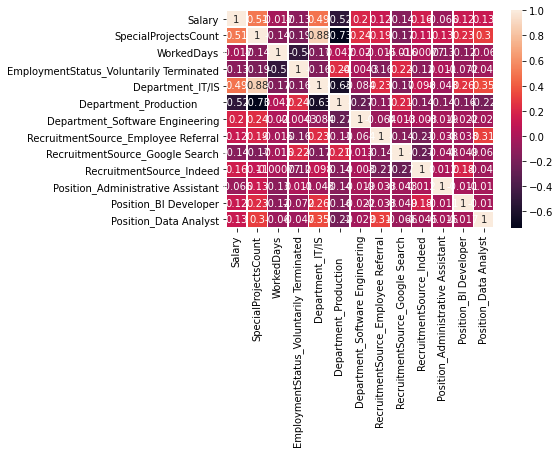

In [75]:
# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
dataset1 = dataset.iloc[:,0:13]
correlacio = dataset1.corr()

plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

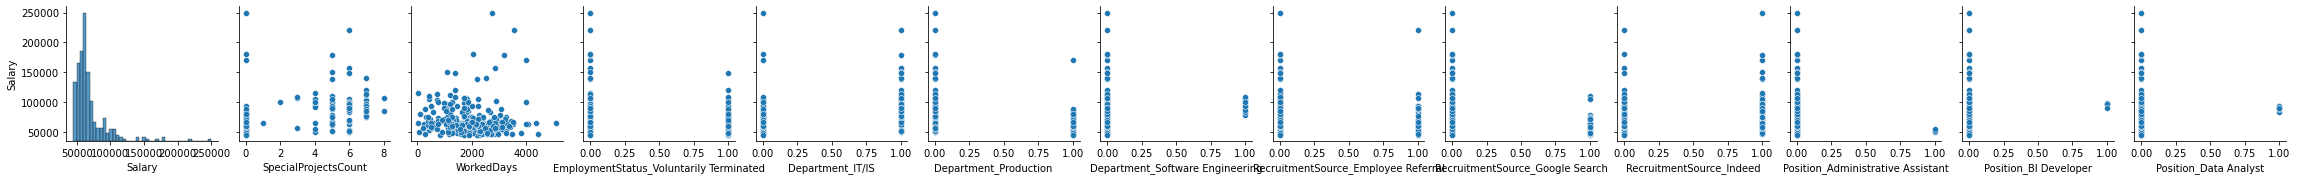

In [76]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset1, y_vars = 'Salary')

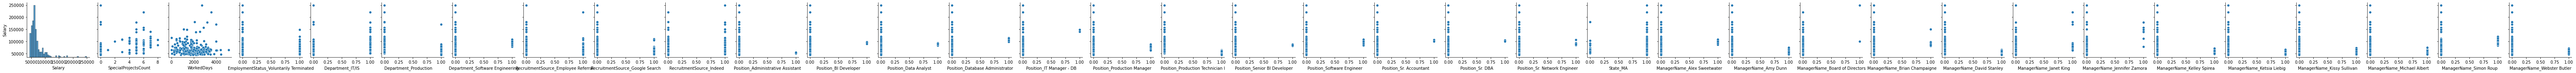

In [77]:
sns.pairplot(dataset, y_vars = 'Salary', x_vars = cols_corr)

### Histogrames

#### Quantitat de persones per rangs de salaris a continuació. Es veu com poques persones cobren molt i la majoria es troba en sous més baixos

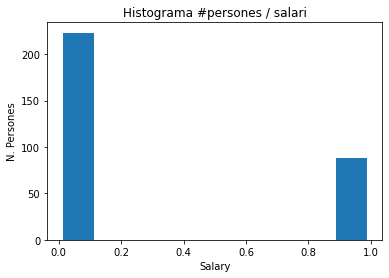

In [78]:
plt.figure()
plt.title("Histograma #persones / salari")
plt.xlabel("Salary")
plt.ylabel("N. Persones")
v = 3
hist = plt.hist(x[:,v], bins=8, range=[np.min(x[:,v]), np.max(x[:,v])], histtype="bar", rwidth=0.8)

### PRIMERES REGRESSIONS

#### Error quadràtic mitjà

In [51]:
def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

def mse(v1, v2):
    return ((v1 - v2)**2).mean()

#### Regressor

In [52]:
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

In [53]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x_t = standarize(x)
#x_t = x

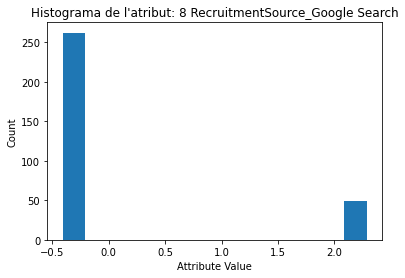

In [54]:
plt.figure()
at = 8
plt.title("Histograma de l'atribut: "+ str(at) +' '+ dataset.columns[at])
plt.xlabel("Attribute Value")
plt.ylabel("Count")
hist = plt.hist(x_t[:,at], bins=11, range=[np.min(x_t[:,at]), np.max(x_t[:,at])], histtype="bar", rwidth=0.8)

l'atribut: 1 SpecialProjectsCount
Mean squeared error:  0.1956131906306944
R2 score:  0.03587936144560766


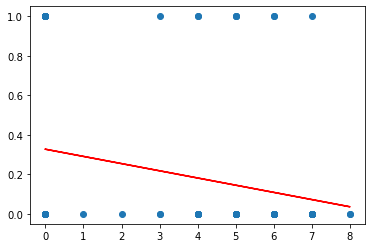

In [55]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
at1 = 1
print("l'atribut: "+ str(at1) +' '+ dataset.columns[at1])
atribut1 = x[:,at1].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,at1], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mse(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

In [58]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    print(dataset.columns[i])
    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))
    print("------------------------------------")

Salary
Error en atribut 0: 0.179539
R2 score en atribut 0: -0.038759
------------------------------------
SpecialProjectsCount
Error en atribut 1: 0.186989
R2 score en atribut 1: -0.081866
------------------------------------
WorkedDays
Error en atribut 2: 0.121828
R2 score en atribut 2: 0.295137
------------------------------------
EmploymentStatus_Voluntarily Terminated
Error en atribut 3: 0.000000
R2 score en atribut 3: 1.000000
------------------------------------
Department_IT/IS
Error en atribut 4: 0.186582
R2 score en atribut 4: -0.079509
------------------------------------
Department_Production       
Error en atribut 5: 0.174828
R2 score en atribut 5: -0.011505
------------------------------------
Department_Software Engineering
Error en atribut 6: 0.179167
R2 score en atribut 6: -0.036607
------------------------------------
RecruitmentSource_Employee Referral
Error en atribut 7: 0.177175
R2 score en atribut 7: -0.025087
------------------------------------
RecruitmentSource

### EL DESCENS DEL GRADIENT